In [25]:
"""
Convex Portfolio Optimization with SciPy (NO CVXPY - Fully Compatible)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from pathlib import Path
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Project setup
project_root = Path.cwd().parent
(project_root / 'results/figures/cvxpy').mkdir(parents=True, exist_ok=True)

print("="*70)
print("CONVEX PORTFOLIO OPTIMIZATION WITH SCIPY")
print("="*70)

# Load data
prices = pd.read_csv(project_root / 'data/processed/prices_clean.csv', index_col=0, parse_dates=True)
returns = pd.read_csv(project_root / 'data/processed/returns_clean.csv', index_col=0, parse_dates=True)

# Load previous models
with open(project_root / 'models/hrp_model.pkl', 'rb') as f:
    hrp_model = pickle.load(f)
with open(project_root / 'models/bl_model.pkl', 'rb') as f:
    bl_model = pickle.load(f)

print(f"✅ Data loaded: {returns.shape}")
print(f"✅ HRP & BL models loaded")
print(f"Date range: {prices.index[0].date()} to {prices.index[-1].date()}")


CONVEX PORTFOLIO OPTIMIZATION WITH SCIPY
✅ Data loaded: (1182, 55)
✅ HRP & BL models loaded
Date range: 2021-03-12 to 2025-11-21


In [26]:
"""
Define sector mapping for constraints
"""

print("\n" + "="*70)
print("SECTOR MAPPING DEFINITION")
print("="*70)

sectors = {
    'Technology': ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'META', 'AVGO', 'ADBE', 'CRM', 'ORCL', 'CSCO'],
    'Financial': ['JPM', 'BAC', 'WFC', 'GS', 'MS', 'C', 'BLK', 'SCHW', 'AXP', 'USB'],
    'Healthcare': ['UNH', 'JNJ', 'LLY', 'ABBV', 'MRK', 'PFE', 'TMO', 'ABT', 'DHR', 'AMGN'],
    'Consumer': ['AMZN', 'TSLA', 'WMT', 'HD', 'MCD', 'NKE', 'SBUX', 'TGT', 'LOW', 'TJX'],
    'Industrial_Energy': ['XOM', 'CVX', 'COP', 'BA', 'CAT', 'RTX', 'HON', 'UPS', 'GE', 'DE'],
    'ETFs': ['SPY', 'QQQ', 'IWM', 'EFA', 'AGG']
}

asset_to_sector = {}
for sector, assets in sectors.items():
    for asset in assets:
        asset_to_sector[asset] = sector

print("Sector definitions:")
for sector, assets in sectors.items():
    print(f"  {sector:.<25} {len(assets)} assets")

print(f"\nTotal sectors: {len(sectors)}")
print(f"Total assets: {sum(len(assets) for assets in sectors.values())}")



SECTOR MAPPING DEFINITION
Sector definitions:
  Technology............... 10 assets
  Financial................ 10 assets
  Healthcare............... 10 assets
  Consumer................. 10 assets
  Industrial_Energy........ 10 assets
  ETFs..................... 5 assets

Total sectors: 6
Total assets: 55


In [27]:
"""
SciPy-based portfolio optimization (CVXPY replacement)
"""

def optimize_portfolio_scipy(expected_returns, cov_matrix, 
                             asset_names,
                             sector_mapping,
                             min_weight=0.01,
                             max_weight=0.10,
                             max_sector_weight=0.40,
                             max_turnover=0.20,
                             prev_weights=None,
                             risk_aversion=1.0):
    """
    Portfolio optimization using SciPy minimize (SLSQP)
    No CVXPY dependencies - pure SciPy
    """
    n = len(expected_returns)
    
    # Objective: minimize -(return - risk_aversion * variance)
    def objective(w):
        portfolio_return = np.dot(expected_returns, w)
        portfolio_variance = np.dot(w, np.dot(cov_matrix, w))
        return -(portfolio_return - risk_aversion * portfolio_variance)
    
    # Constraints
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}  # Fully invested
    ]
    
    # Sector constraints
    for sector, members in sector_mapping.items():
        sector_indices = [i for i, asset in enumerate(asset_names) if asset in members]
        if sector_indices:
            constraints.append({
                'type': 'ineq',
                'fun': lambda w, idx=sector_indices: max_sector_weight - np.sum(w[idx])
            })
    
    # Turnover constraint
    if prev_weights is not None:
        constraints.append({
            'type': 'ineq',
            'fun': lambda w: max_turnover - np.sum(np.abs(w - prev_weights))
        })
    
    # Bounds
    bounds = tuple((min_weight, max_weight) for _ in range(n))
    
    # Initial guess
    w0 = np.ones(n) / n
    
    # Optimize
    result = minimize(
        objective,
        w0,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'ftol': 1e-9, 'maxiter': 1000}
    )
    
    if not result.success:
        print(f"⚠️ Optimization warning: {result.message}")
        if result.fun < 1e6:
            print("   Accepting near-optimal solution")
            return result.x
        return None
    
    return result.x

print("="*70)
print("SCIPY OPTIMIZATION FUNCTION DEFINED")
print("="*70)
print("✅ Function: optimize_portfolio_scipy()")
print("✅ No CVXPY - pure SciPy SLSQP solver")
print("\nConstraints:")
print("  1. Sum = 1 (fully invested)")
print("  2. Min 1%, Max 10% per asset")
print("  3. Max 40% per sector")
print("  4. Max 20% turnover")
print("  5. Long-only (w >= 0)")


SCIPY OPTIMIZATION FUNCTION DEFINED
✅ Function: optimize_portfolio_scipy()
✅ No CVXPY - pure SciPy SLSQP solver

Constraints:
  1. Sum = 1 (fully invested)
  2. Min 1%, Max 10% per asset
  3. Max 40% per sector
  4. Max 20% turnover
  5. Long-only (w >= 0)


In [28]:
"""
Calculate optimal portfolio using SciPy
"""

print("\n" + "="*70)
print("STEP 1: CALCULATE OPTIMAL WEIGHTS")
print("="*70)

lookback_period = 252
recent_returns = returns.iloc[-lookback_period:]

print(f"Using {lookback_period} days")
print(f"Date range: {recent_returns.index[0].date()} to {recent_returns.index[-1].date()}")

# Calculate inputs
expected_returns = recent_returns.mean() * 252
cov_matrix = recent_returns.cov() * 252

print(f"\nExpected returns (top 10):")
print(expected_returns.sort_values(ascending=False).head(10))

# Optimize
scipy_weights = optimize_portfolio_scipy(
    expected_returns.values,
    cov_matrix.values,
    returns.columns.tolist(),
    sectors,
    min_weight=0.01,
    max_weight=0.10,
    max_sector_weight=0.40,
    max_turnover=None,
    prev_weights=None,
    risk_aversion=1.0
)

if scipy_weights is not None:
    scipy_weights_series = pd.Series(scipy_weights, index=returns.columns)
    
    print(f"\n✅ Optimization successful!")
    print(f"\nOptimal Weights (Top 20):")
    print(scipy_weights_series.sort_values(ascending=False).head(20))
    
    print(f"\nWeight Statistics:")
    print(f"  Sum: {scipy_weights_series.sum():.6f}")
    print(f"  Mean: {scipy_weights_series.mean():.4f}")
    print(f"  Max: {scipy_weights_series.max():.4f}")
    print(f"  Min: {scipy_weights_series.min():.4f}")
    print(f"  Herfindahl: {(scipy_weights_series ** 2).sum():.4f}")
    print(f"  Effective #: {1 / (scipy_weights_series ** 2).sum():.1f}")
    
    # Verify sector constraints
    print(f"\nSector Allocations (≤40%):")
    for sector, members in sectors.items():
        sector_weight = scipy_weights_series[scipy_weights_series.index.isin(members)].sum()
        status = "✅" if sector_weight <= 0.40 else "❌"
        print(f"  {sector:.<25} {sector_weight:>6.2%} {status}")
    
    # Expected metrics
    portfolio_return = scipy_weights @ expected_returns.values
    portfolio_vol = np.sqrt(scipy_weights @ cov_matrix.values @ scipy_weights)
    portfolio_sharpe = (portfolio_return - 0.02) / portfolio_vol
    
    print(f"\nExpected Metrics:")
    print(f"  Return: {portfolio_return:.2%}")
    print(f"  Volatility: {portfolio_vol:.2%}")
    print(f"  Sharpe: {portfolio_sharpe:.3f}")
else:
    print("❌ Optimization failed")
    scipy_weights_series = pd.Series(1.0 / len(returns.columns), index=returns.columns)



STEP 1: CALCULATE OPTIMAL WEIGHTS
Using 252 days
Date range: 2024-11-20 to 2025-11-21

Expected returns (top 10):
AVGO     0.895285
GOOGL    0.579385
GE       0.535304
LLY      0.462949
C        0.440577
CAT      0.428029
ABBV     0.418022
RTX      0.410279
GS       0.354482
CSCO     0.341960
dtype: float64

✅ Optimization successful!

Optimal Weights (Top 20):
ABBV     0.10
LLY      0.10
AVGO     0.10
GOOGL    0.10
GE       0.10
ADBE     0.01
NVDA     0.01
CRM      0.01
UNH      0.01
COP      0.01
ORCL     0.01
WFC      0.01
TSLA     0.01
QQQ      0.01
GS       0.01
TGT      0.01
LOW      0.01
META     0.01
AMZN     0.01
NKE      0.01
dtype: float64

Weight Statistics:
  Sum: 1.000000
  Mean: 0.0182
  Max: 0.1000
  Min: 0.0100
  Herfindahl: 0.0550
  Effective #: 18.2

Sector Allocations (≤40%):
  Technology............... 28.00% ✅
  Financial................ 10.00% ✅
  Healthcare............... 28.00% ✅
  Consumer................. 10.00% ✅
  Industrial_Energy........ 19.00% ✅
  ETFs.


STEP 2: COMPARE SCIPY vs HRP vs BL
Comparison (Top 20 by SciPy):
       SciPy_Optimal       HRP  Black_Litterman  Equal_Weighted
ABBV            0.10  0.005716         0.020995        0.018182
LLY             0.10  0.008047         0.014835        0.018182
AVGO            0.10  0.001301         0.022670        0.018182
GOOGL           0.10  0.003992         0.005842        0.018182
GE              0.10  0.004175         0.021814        0.018182
ADBE            0.01  0.005019         0.021320        0.018182
NVDA            0.01  0.001444         0.004025        0.018182
CRM             0.01  0.005513         0.023367        0.018182
UNH             0.01  0.006540         0.015463        0.018182
COP             0.01  0.003280         0.001000        0.018182
ORCL            0.01  0.001996         0.020668        0.018182
WFC             0.01  0.002531         0.021665        0.018182
TSLA            0.01  0.000899         0.021713        0.018182
QQQ             0.01  0.003602        

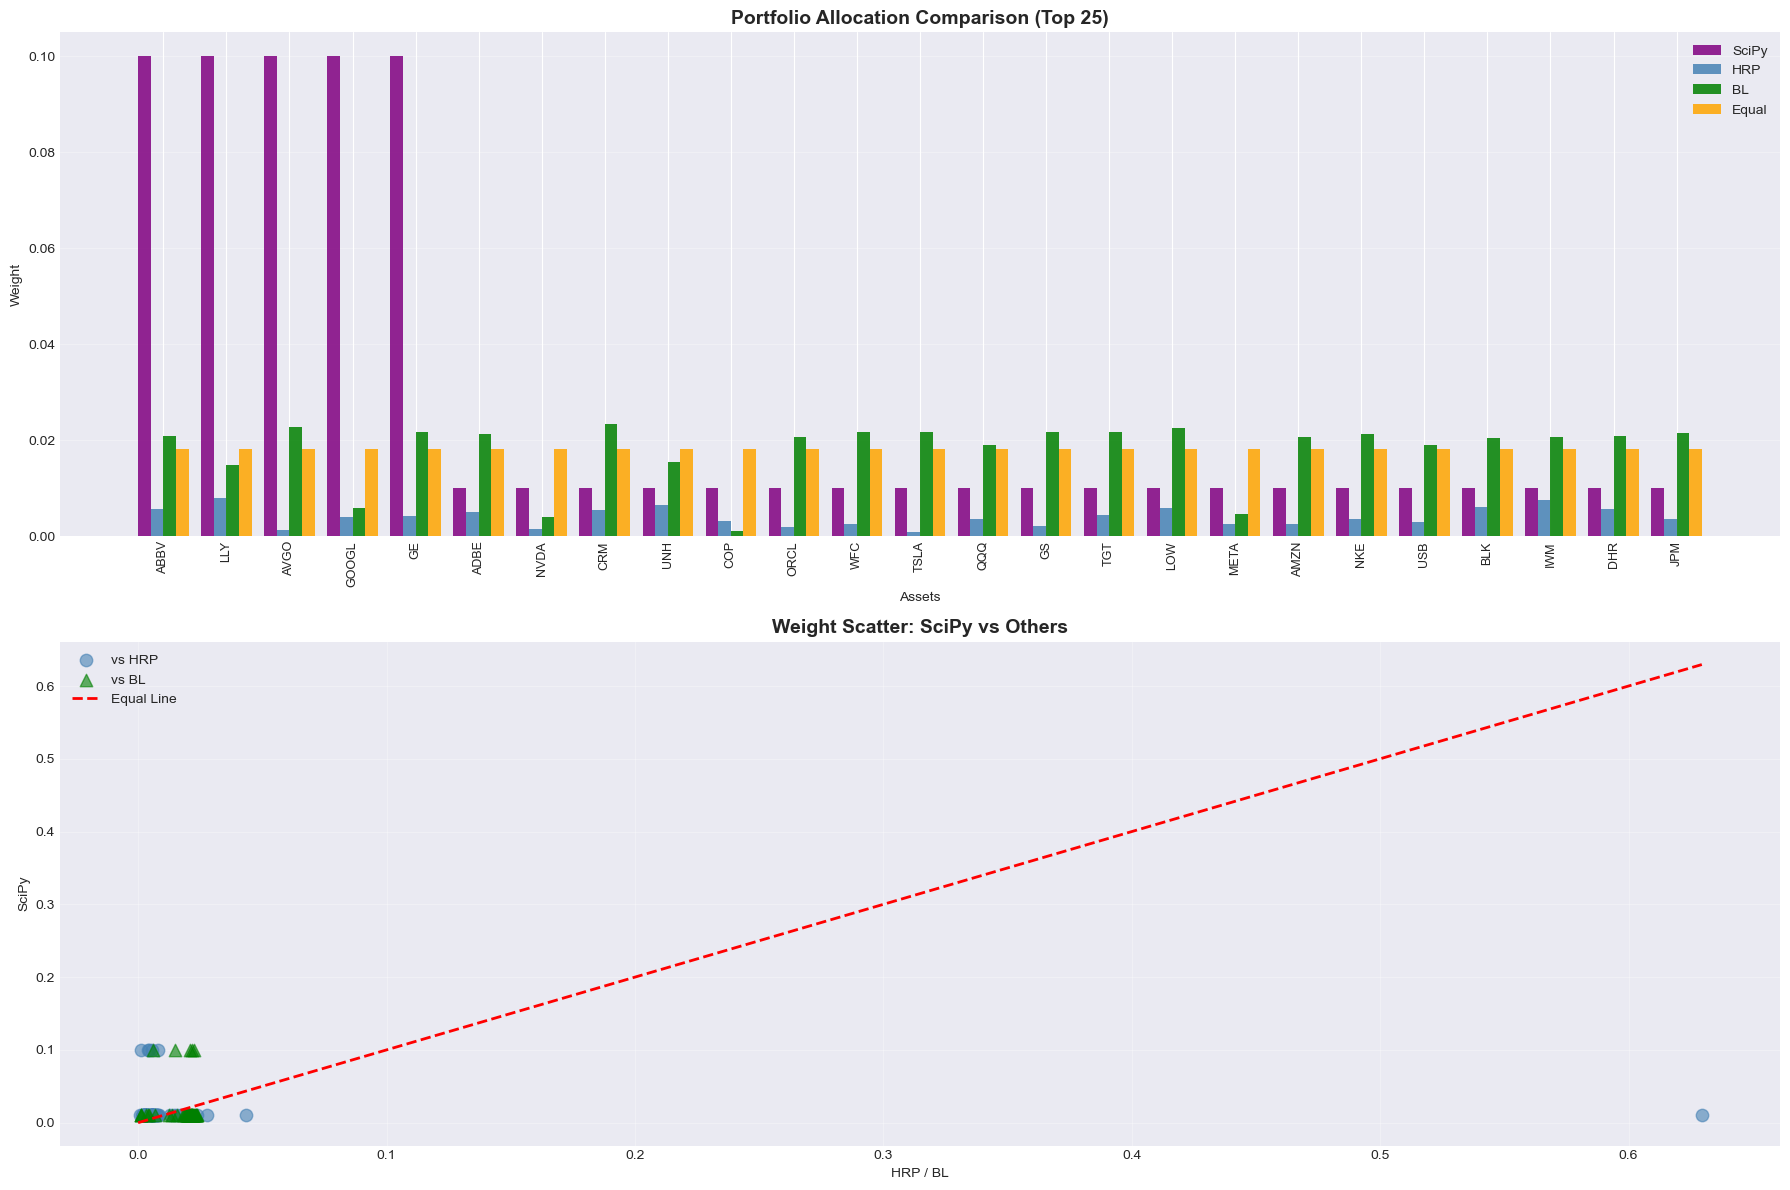


✅ Comparison saved


In [29]:
"""
Compare SciPy vs HRP vs BL
"""

print("\n" + "="*70)
print("STEP 2: COMPARE SCIPY vs HRP vs BL")
print("="*70)

hrp_weights = hrp_model['weights']
bl_weights = bl_model['weights']

comparison = pd.DataFrame({
    'SciPy_Optimal': scipy_weights_series,
    'HRP': hrp_weights,
    'Black_Litterman': bl_weights,
    'Equal_Weighted': pd.Series(1.0 / len(returns.columns), index=returns.columns)
})

print("Comparison (Top 20 by SciPy):")
print(comparison.sort_values('SciPy_Optimal', ascending=False).head(20))

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Bar chart
ax1 = axes[0]
top_25 = comparison.sort_values('SciPy_Optimal', ascending=False).head(25)
x = np.arange(len(top_25))
width = 0.2

ax1.bar(x - 1.5*width, top_25['SciPy_Optimal'], width, label='SciPy', alpha=0.85, color='purple')
ax1.bar(x - 0.5*width, top_25['HRP'], width, label='HRP', alpha=0.85, color='steelblue')
ax1.bar(x + 0.5*width, top_25['Black_Litterman'], width, label='BL', alpha=0.85, color='green')
ax1.bar(x + 1.5*width, top_25['Equal_Weighted'], width, label='Equal', alpha=0.85, color='orange')

ax1.set_title('Portfolio Allocation Comparison (Top 25)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Weight')
ax1.set_xlabel('Assets')
ax1.set_xticks(x)
ax1.set_xticklabels(top_25.index, rotation=90, fontsize=9)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Scatter
ax2 = axes[1]
ax2.scatter(comparison['HRP'], comparison['SciPy_Optimal'], s=80, alpha=0.6, label='vs HRP', color='steelblue')
ax2.scatter(comparison['Black_Litterman'], comparison['SciPy_Optimal'], s=80, alpha=0.6, label='vs BL', color='green', marker='^')
max_val = comparison[['SciPy_Optimal', 'HRP', 'Black_Litterman']].max().max()
ax2.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Equal Line')
ax2.set_title('Weight Scatter: SciPy vs Others', fontsize=14, fontweight='bold')
ax2.set_xlabel('HRP / BL')
ax2.set_ylabel('SciPy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'results/figures/cvxpy/01_weight_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Comparison saved")


In [30]:
"""
Quarterly rebalancing backtest
"""

print("\n" + "="*70)
print("STEP 3: QUARTERLY BACKTEST")
print("="*70)

def backtest_strategy_quarterly(returns, strategy_func, name="Strategy"):
    backtest_start = '2019-01-01'
    backtest_returns = returns.loc[backtest_start:]
    quarterly_dates = pd.date_range(start=backtest_start, end=returns.index[-1], freq='Q')
    
    weights_history = {}
    portfolio_returns_list = []
    current_weights = None
    
    print(f"\nBacktesting {name}...")
    
    for date in backtest_returns.index:
        if current_weights is None or date in quarterly_dates:
            available_dates = backtest_returns.index[backtest_returns.index <= date]
            if len(available_dates) == 0:
                continue
            
            actual_date = available_dates[-1]
            lookback_start = backtest_returns.index.get_loc(actual_date) - 252
            if lookback_start < 0:
                lookback_start = 0
            
            hist_returns = backtest_returns.iloc[lookback_start:backtest_returns.index.get_loc(actual_date)]
            
            if len(hist_returns) > 60:
                current_weights = strategy_func(hist_returns)
                if current_weights is not None:
                    weights_history[actual_date] = current_weights
        
        if current_weights is not None:
            day_return = (backtest_returns.loc[date] * current_weights).sum()
            portfolio_returns_list.append({'date': date, 'return': day_return})
    
    portfolio_returns_df = pd.DataFrame(portfolio_returns_list)
    portfolio_returns = portfolio_returns_df.set_index('date')['return']
    
    print(f"  ✅ Complete: {len(portfolio_returns)} days")
    
    return portfolio_returns, weights_history

def scipy_strategy(hist_returns):
    exp_ret = hist_returns.mean() * 252
    cov = hist_returns.cov() * 252
    
    weights = optimize_portfolio_scipy(
        exp_ret.values,
        cov.values,
        returns.columns.tolist(),
        sectors,
        min_weight=0.01,
        max_weight=0.10,
        max_sector_weight=0.40,
        risk_aversion=1.0
    )
    
    return pd.Series(weights, index=returns.columns) if weights is not None else None

scipy_returns, scipy_weights_hist = backtest_strategy_quarterly(
    returns, scipy_strategy, "SciPy Optimal"
)

print("\n✅ Backtest complete")



STEP 3: QUARTERLY BACKTEST

Backtesting SciPy Optimal...
  ✅ Complete: 1121 days

✅ Backtest complete


In [31]:
"""
Calculate performance metrics
"""

def calculate_performance_metrics(returns_series, strategy_name="Strategy"):
    returns_clean = returns_series.dropna()
    if len(returns_clean) == 0:
        return None
    
    cum_ret = (1 + returns_clean).cumprod()
    total_return = cum_ret.iloc[-1] - 1
    n_years = len(returns_clean) / 252
    ann_return = (1 + total_return) ** (1 / n_years) - 1
    ann_vol = returns_clean.std() * np.sqrt(252)
    sharpe = (ann_return - 0.02) / ann_vol if ann_vol > 0 else 0
    
    downside_returns = returns_clean[returns_clean < 0]
    if len(downside_returns) > 0:
        downside_std = np.sqrt((downside_returns ** 2).mean()) * np.sqrt(252)
        sortino = (ann_return - 0.02) / downside_std if downside_std > 0 else 0
    else:
        sortino = np.nan
    
    drawdown = (cum_ret - cum_ret.cummax()) / cum_ret.cummax()
    max_dd = drawdown.min()
    calmar = ann_return / abs(max_dd) if max_dd != 0 else 0
    win_rate = (returns_clean > 0).sum() / len(returns_clean)
    
    return {
        'Strategy': strategy_name,
        'Total Return': total_return,
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown': max_dd,
        'Calmar Ratio': calmar,
        'Win Rate': win_rate
    }

scipy_metrics = calculate_performance_metrics(scipy_returns, "SciPy Optimal")
print(f"\nSciPy Metrics:")
for key, value in scipy_metrics.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")



SciPy Metrics:
  Strategy: SciPy Optimal
  Total Return: 1.3086
  Annualized Return: 0.2069
  Annualized Volatility: 0.1980
  Sharpe Ratio: 0.9443
  Sortino Ratio: 0.9212
  Max Drawdown: -0.2482
  Calmar Ratio: 0.8337
  Win Rate: 0.5575


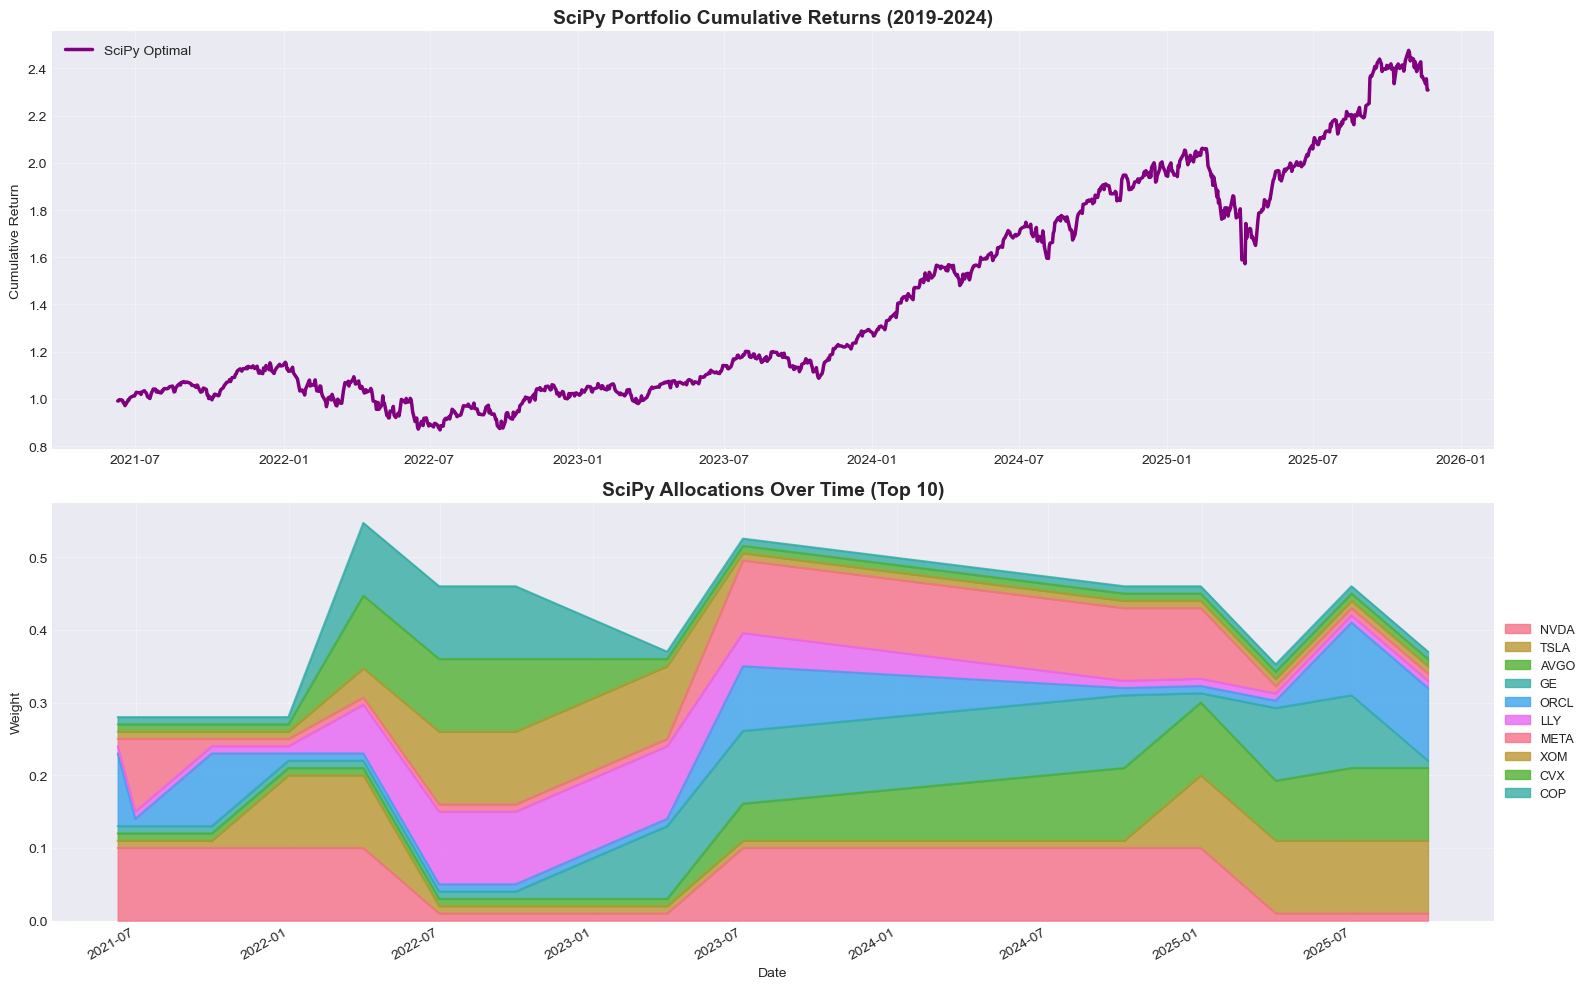

✅ Visualizations saved


In [32]:
"""
Visualize performance
"""

scipy_cumulative = (1 + scipy_returns.dropna()).cumprod()

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Cumulative returns
axes[0].plot(scipy_cumulative.index, scipy_cumulative.values, label='SciPy Optimal', color='purple', linewidth=2.5)
axes[0].set_title('SciPy Portfolio Cumulative Returns (2019-2024)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cumulative Return')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Allocations over time
weight_history_df = pd.DataFrame(scipy_weights_hist).T
top_assets = weight_history_df.mean().sort_values(ascending=False).head(10).index
weight_history_top = weight_history_df[top_assets]
weight_history_top.plot(kind='area', stacked=True, ax=axes[1], alpha=0.8)
axes[1].set_title('SciPy Allocations Over Time (Top 10)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Weight')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'results/figures/cvxpy/02_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations saved")


In [33]:
"""
Save SciPy model and results
"""

scipy_model = {
    'weights': scipy_weights_series,
    'weights_history': scipy_weights_hist,
    'expected_returns': expected_returns,
    'covariance_matrix': cov_matrix,
    'constraints': {
        'min_weight': 0.01,
        'max_weight': 0.10,
        'max_sector_weight': 0.40,
        'risk_aversion': 1.0
    },
    'calculation_date': returns.index[-1],
    'performance_metrics': scipy_metrics
}

with open(project_root / 'models/scipy_optimal_model.pkl', 'wb') as f:
    pickle.dump(scipy_model, f)

print("✅ Model saved to models/scipy_optimal_model.pkl")
print("\n" + "="*70)
print("NOTEBOOK 6 COMPLETE")
print("="*70)


✅ Model saved to models/scipy_optimal_model.pkl

NOTEBOOK 6 COMPLETE
